# Improved Light PPI Prediction

This notebook provides a flexible framework for protein-protein interaction (PPI) prediction using ProteomeLM attention mechanisms. It supports multiple data sources:

1. **Local FASTA file**: Upload your own protein sequences
2. **STRING database**: Download sequences by organism ID
3. **UniProt database**: Download sequences by taxon ID
4. **UniProt IDs**: Fetch specific protein sequences

The workflow includes:
- Flexible data collection
- ProteomeLM inference with attention extraction
- PPI prediction using pre-trained logistic regression models
- STRING annotation comparison and evaluation

## Setup and Imports

In [40]:
import logging
import sys
import shutil
import pickle
import torch

import matplotlib.pyplot as plt
import numpy as np

import ipywidgets as widgets
from IPython.display import display

sys.path.append("..")
from proteomelm.ppi.model import prepare_ppi
from notebooks_utils import *

from proteomelm.ppi.model import EnhancedPPIModel

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set plot style
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14

## Data Collection Configuration

Configure your data source by setting exactly one of the following options:
- `fasta_file`: Path to a local FASTA file
- `string_id`: STRING database organism ID (e.g., "9606" for human)
- `taxon_id`: NCBI taxon ID for UniProt download
- `uniprot_ids`: List of specific UniProt accession IDs

In [41]:
# Create interactive widgets for configuration
print("=== PPI Prediction Configuration ===")

# Data source selection
data_source_type = widgets.Dropdown(
    options=[
        ('Upload FASTA file', 'fasta'),
        ('STRING organism ID', 'string'),
        ('UniProt taxon ID', 'taxon'),
        ('UniProt accession IDs', 'uniprot_ids')
    ],
    value='string',
    description='Data source:',
    style={'description_width': 'initial'}
)

# Input fields for different data sources
fasta_file_input = widgets.FileUpload(
    accept='.fasta,.fa,.fas,.seq',
    multiple=False,
    description='Upload FASTA file:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='500px')
)

string_id_input = widgets.Text(
    value='511145',
    placeholder='e.g., 511145 for E. coli',
    description='STRING organism ID:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

taxon_id_input = widgets.Text(
    value='',
    placeholder='e.g., 9606',
    description='NCBI taxon ID:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

uniprot_ids_input = widgets.Textarea(
    value='',
    placeholder='Enter UniProt IDs separated by commas or newlines\ne.g., P12345, Q67890, A12345',
    description='UniProt IDs:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='500px', height='100px')
)

# Additional options
get_annotations_checkbox = widgets.Checkbox(
    value=True,
    description='Download STRING annotations for comparison',
    style={'description_width': 'initial'}
)

organism_name_input = widgets.Text(
    value='Custom Organism',
    placeholder='e.g., H. sapiens, E. coli',
    description='Organism name:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

# Model configuration
checkpoint_input = widgets.Dropdown(
    options=[
        ('ProteomeLM-XS', '../weights/ProteomeLM-XS'),
        ('ProteomeLM-S', '../weights/ProteomeLM-S'),
        ('ProteomeLM-M', '../weights/ProteomeLM-M'),
        ('ProteomeLM-L', '../weights/ProteomeLM-L')
    ],
    value='../weights/ProteomeLM-S',
    description='Model checkpoint:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='500px')
)

esm_device_input = widgets.Dropdown(
    options=['cuda:0', 'cuda:1', 'cpu'],
    value='cuda:0',
    description='ESM device:',
    style={'description_width': 'initial'}
)

proteomelm_device_input = widgets.Dropdown(
    options=['cpu', 'cuda:0', 'cuda:1'],
    value='cpu',
    description='ProteomeLM device:',
    style={'description_width': 'initial'}
)

# Supervised PPI prediction options
use_supervised_ppi = widgets.Checkbox(
    value=True,
    description='Use supervised PPI prediction',
    style={'description_width': 'initial'}
)

supervised_ppi_checkpoint = widgets.Dropdown(
    options=[
        ('Bernett model', '../data/interactomes/enhanced_ppi_model_bernett.pt'),
        ('D-SCRIPT model', '../data/interactomes/enhanced_ppi_model_dscript.pt')
    ],
    value='../data/interactomes/enhanced_ppi_model_bernett.pt',
    description='Supervised PPI checkpoint:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='600px')
)

# Warning label for supervised PPI
supervised_ppi_warning = widgets.HTML(
    value='<div style="background-color: #fff3cd; border: 1px solid #ffeaa7; '
          'color: #856404; padding: 8px; border-radius: 4px; margin: 5px 0;">'
          '<b>⚠️ Note:</b> Supervised PPI prediction currently requires ProteomeLM-S checkpoint</div>',
    layout=widgets.Layout(width='600px')
)

logreg_model_input = widgets.Dropdown(
    options=[
        ('Human model', '../data/interactomes/logistic_regression_model_human.pkl'),
        ('Pathogen model', '../data/interactomes/logistic_regression_model_pathogen.pkl'),
        ('No regression (sum the attention scores)', None)
    ],
    value='../data/interactomes/logistic_regression_model_human.pkl',
    description='Logistic regression model:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='600px')
)

# Function to show/hide input fields based on data source selection
def update_visibility(change):
    data_type = change['new']
    
    # Hide all inputs first
    fasta_file_input.layout.display = 'none'
    string_id_input.layout.display = 'none'
    taxon_id_input.layout.display = 'none'
    uniprot_ids_input.layout.display = 'none'
    
    # Show relevant input
    if data_type == 'fasta':
        fasta_file_input.layout.display = 'block'
    elif data_type == 'string':
        string_id_input.layout.display = 'block'
    elif data_type == 'taxon':
        taxon_id_input.layout.display = 'block'
    elif data_type == 'uniprot_ids':
        uniprot_ids_input.layout.display = 'block'

# Function to show/hide supervised PPI options
def update_supervised_visibility(change):
    use_supervised = change['new']
    
    if use_supervised:
        supervised_ppi_checkpoint.layout.display = 'block'
        supervised_ppi_warning.layout.display = 'block'
    else:
        supervised_ppi_checkpoint.layout.display = 'none'
        supervised_ppi_warning.layout.display = 'none'

# Set up the observers
data_source_type.observe(update_visibility, names='value')
use_supervised_ppi.observe(update_supervised_visibility, names='value')

# Initial visibility setup
update_visibility({'new': data_source_type.value})
update_supervised_visibility({'new': use_supervised_ppi.value})

# Display the configuration interface
print("📁 Data Source Configuration:")
display(data_source_type)
display(fasta_file_input)
display(string_id_input)
display(taxon_id_input)
display(uniprot_ids_input)

print("\n⚙️ Analysis Options:")
display(get_annotations_checkbox)
display(organism_name_input)

print("\n🤖 Model Configuration:")
display(checkpoint_input)
display(esm_device_input)
display(proteomelm_device_input)

print("\n📊 Unsupervised PPI Prediction:")
display(logreg_model_input)

print("\n🧠 Supervised PPI Prediction:")
display(use_supervised_ppi)
display(supervised_ppi_checkpoint)
display(supervised_ppi_warning)

# Function to extract configuration values
def get_config():
    """Extract current configuration values from widgets."""
    config = {
        'fasta_file': None,
        'string_id': None,
        'taxon_id': None,
        'uniprot_ids': None,
        'get_string_annotations': get_annotations_checkbox.value,
        'organism_name': organism_name_input.value,
        'checkpoint': checkpoint_input.value,
        'esm_device': esm_device_input.value,
        'proteomelm_device': proteomelm_device_input.value,
        'use_supervised_ppi': use_supervised_ppi.value,
        'supervised_ppi_checkpoint': supervised_ppi_checkpoint.value,
        'logreg_model_path': logreg_model_input.value
    }
    
    # Set the appropriate data source based on selection
    data_type = data_source_type.value
    if data_type == 'fasta' and fasta_file_input.value.strip():
        config['fasta_file'] = fasta_file_input.value.strip()
    elif data_type == 'string' and string_id_input.value.strip():
        config['string_id'] = string_id_input.value.strip()
    elif data_type == 'taxon' and taxon_id_input.value.strip():
        config['taxon_id'] = taxon_id_input.value.strip()
    elif data_type == 'uniprot_ids' and uniprot_ids_input.value.strip():
        # Parse comma or newline separated UniProt IDs
        ids_text = uniprot_ids_input.value.strip()
        ids = [id_.strip() for id_ in ids_text.replace('\n', ',').split(',') if id_.strip()]
        config['uniprot_ids'] = ids if ids else None
    
    return config

print("\n✅ Configuration ready! Run the next cell to start analysis.")

=== PPI Prediction Configuration ===
📁 Data Source Configuration:


Dropdown(description='Data source:', index=1, options=(('Upload FASTA file', 'fasta'), ('STRING organism ID', …

FileUpload(value=(), accept='.fasta,.fa,.fas,.seq', description='Upload FASTA file:', layout=Layout(display='n…

Text(value='511145', description='STRING organism ID:', layout=Layout(display='block', width='300px'), placeho…

Text(value='', description='NCBI taxon ID:', layout=Layout(display='none', width='300px'), placeholder='e.g., …

Textarea(value='', description='UniProt IDs:', layout=Layout(display='none', height='100px', width='500px'), p…


⚙️ Analysis Options:


Checkbox(value=True, description='Download STRING annotations for comparison', style=CheckboxStyle(description…

Text(value='Custom Organism', description='Organism name:', layout=Layout(width='400px'), placeholder='e.g., H…


🤖 Model Configuration:


Dropdown(description='Model checkpoint:', index=1, layout=Layout(width='500px'), options=(('ProteomeLM-XS', '.…

Dropdown(description='ESM device:', options=('cuda:0', 'cuda:1', 'cpu'), style=DescriptionStyle(description_wi…

Dropdown(description='ProteomeLM device:', options=('cpu', 'cuda:0', 'cuda:1'), style=DescriptionStyle(descrip…


📊 Unsupervised PPI Prediction:


Dropdown(description='Logistic regression model:', layout=Layout(width='600px'), options=(('Human model', '../…


🧠 Supervised PPI Prediction:


Checkbox(value=True, description='Use supervised PPI prediction', style=CheckboxStyle(description_width='initi…

Dropdown(description='Supervised PPI checkpoint:', layout=Layout(display='block', width='600px'), options=(('B…

HTML(value='<div style="background-color: #fff3cd; border: 1px solid #ffeaa7; color: #856404; padding: 8px; bo…


✅ Configuration ready! Run the next cell to start analysis.


## Data Collection and Preparation

In [ ]:
# Get configuration from widgets
config = get_config()

# Extract configuration values
fasta_file = config['fasta_file']
string_id = config['string_id']
taxon_id = config['taxon_id']
uniprot_ids = config['uniprot_ids']
get_string_annotations = config['get_string_annotations']
organism_name = config['organism_name']
checkpoint = config['checkpoint']
esm_device = config['esm_device']
proteomelm_device = config['proteomelm_device']
logreg_model_path = config['logreg_model_path']
supervised_ppi_checkpoint = config['supervised_ppi_checkpoint']
use_supervised_ppi = config['use_supervised_ppi']

# Initialize variables
labels = None
sequences = None
mapping = None
uniprot_fasta_file = "temp_uniprot.fa"

# Validate configuration
data_sources = [fasta_file, string_id, taxon_id, uniprot_ids]
active_sources = [src for src in data_sources if src is not None]
if len(active_sources) == 0:
    raise ValueError("Please configure exactly one data source in the configuration cell above")
elif len(active_sources) > 1:
    raise ValueError("Please configure exactly one data source (multiple sources detected)")

# Collect protein sequences based on configuration
if fasta_file is not None:
    logging.info(f"Loading sequences from local FASTA file: {fasta_file}")
    labels, sequences = load_fasta(fasta_file)
    # Copy to standard filename for downstream processing
    shutil.copy(fasta_file, uniprot_fasta_file)
    
elif string_id is not None:
    logging.info(f"Downloading sequences from STRING database for organism: {string_id}")
    labels, sequences = download_string_fasta(string_id)
    # Copy string fasta to uniprot fasta for processing
    if os.path.exists("temp_string.fa"):
        shutil.copy("temp_string.fa", uniprot_fasta_file)
        
elif taxon_id is not None:
    logging.info(f"Downloading sequences from UniProt for taxon ID: {taxon_id}")
    url = f"https://rest.uniprot.org/uniprotkb/stream?format=fasta&query=organism_id:{taxon_id}"
    response = requests.get(url)
    if response.status_code == 200:
        with open(uniprot_fasta_file, "wb") as f:
            f.write(response.content)
        labels, sequences = load_fasta(uniprot_fasta_file)
    else:
        raise Exception(f"Failed to download FASTA file for taxon ID {taxon_id}. Status code: {response.status_code}.")
        
elif uniprot_ids is not None:
    logging.info(f"Fetching {len(uniprot_ids)} sequences from UniProt")
    sequences_dict = fetch_uniprot_sequences_batch(uniprot_ids)
    labels = list(sequences_dict.keys())
    sequences = list(sequences_dict.values())
    
    # Write to FASTA file
    with open(uniprot_fasta_file, "w") as f:
        for label, seq in zip(labels, sequences):
            f.write(f">{label}\n{seq}\n")

logging.info(f"Loaded {len(labels)} protein sequences")
logging.info(f"Sample labels: {labels[:3]}")
logging.info(f"Configuration: organism='{organism_name}', annotations={get_string_annotations}")
print(f"✅ Successfully loaded {len(labels)} protein sequences for {organism_name}")

2025-08-15 16:04:03,384 - INFO - root - Downloading sequences from STRING database for organism: 511145
2025-08-15 16:04:03,538 - INFO - root - Loaded 4140 protein sequences
2025-08-15 16:04:03,539 - INFO - root - Sample labels: ['511145.b0001', '511145.b0002', '511145.b0003']
2025-08-15 16:04:03,540 - INFO - root - Configuration: organism='Custom Organism', annotations=True
✅ Successfully loaded 4140 protein sequences for Custom Organism


## STRING Annotations Collection

In [7]:
string_scores = None
string_labels = None

if get_string_annotations:
    logging.info("Collecting STRING interaction annotations...")
    
    # Determine which organism ID to use for STRING annotations
    string_organism_id = string_id if string_id is not None else taxon_id
    
    if string_organism_id is not None:
        # Download STRING annotations
        annotations_file = download_string_annotations(str(string_organism_id))
        
        # If we're not using STRING sequences directly, we need to map
        if string_id is None:
            # Download STRING sequences for mapping
            download_string_fasta(str(string_organism_id))
            mapping = map_string_to_uniprot(uniprot_fasta_file, "temp_string.fa")
            logging.info(f"Created mapping for {len(mapping)} proteins")
        
        # Process STRING annotations
        all_string_interactions = []
        with open(annotations_file, "r") as f:
            next(f)  # Skip header line
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    protein1, protein2 = parts[0], parts[1]
                    score = int(parts[-1])  # combined_score is the last column
                    
                    # Apply mapping if needed
                    if mapping is not None:
                        protein1 = mapping.get(protein1, protein1)
                        protein2 = mapping.get(protein2, protein2)
                    
                    all_string_interactions.append((protein1, protein2, score))
        
        # Create interaction matrix
        n_proteins = len(labels)
        protein_to_idx = {label: i for i, label in enumerate(labels)}
        
        y_matrix = np.zeros((n_proteins, n_proteins), dtype=int)
        
        for protein1, protein2, score in all_string_interactions:
            if protein1 == protein2:
                continue
            if protein1 in protein_to_idx and protein2 in protein_to_idx:
                i, j = protein_to_idx[protein1], protein_to_idx[protein2]
                y_matrix[i, j] = score
                y_matrix[j, i] = score  # Make symmetric
        
        # Convert to upper triangular vector
        string_scores = y_matrix[np.triu_indices(n_proteins, k=1)]
        string_labels = string_scores >= 150  # Basic threshold for interactions
        
        logging.info(f"Found {np.sum(string_labels)} interactions out of {len(string_labels)} possible pairs")
        logging.info(f"Interaction rate: {np.sum(string_labels)/len(string_labels):.2%}")
        
        # Save STRING labels
        np.save("temp_string_labels.npy", string_scores)
        logging.info("STRING labels saved to temp_string_labels.npy")
    else:
        logging.warning("Cannot download STRING annotations: no organism ID provided")

2025-08-15 16:04:08,401 - INFO - root - Collecting STRING interaction annotations...
2025-08-15 16:04:11,291 - INFO - root - Found 492380 interactions out of 8567730 possible pairs
2025-08-15 16:04:11,297 - INFO - root - Interaction rate: 5.75%
2025-08-15 16:04:11,357 - INFO - root - STRING labels saved to temp_string_labels.npy


## ProteomeLM Feature Extraction

In [8]:
# ProteomeLM inference
logging.info("Starting ProteomeLM feature extraction...")

encoded_genome_file = "temp_proteome_encoded.pt"

output = prepare_ppi(
    checkpoint,
    uniprot_fasta_file,
    encoded_genome_file=encoded_genome_file,
    keep_heads=None,
    esm_device=esm_device,
    proteomelm_device=proteomelm_device,
    use_odb=False,
    include_attention=True,
    include_all_hidden_states=False,
    reload_if_possible=True
)

# Extract representations and attention
representations = output["plm_logits"][0]
attention = np.concatenate([att.float() for att in output["plm_attentions"]], 0)
attention = attention.transpose(2, 3, 0, 1)

# Remove self-attention (diagonal)
attention[np.arange(attention.shape[0]), np.arange(attention.shape[0])] = 0

# Make attention symmetric
A = (attention + attention.transpose(1, 0, 2, 3)) / 2

# Convert to pairwise features for upper triangular matrix
n_proteins = A.shape[0]
triu_indices = np.triu_indices(n_proteins, k=1)
pairwise_features = A[triu_indices]  # Shape: (n_pairs, n_layers, n_heads)

# Flatten to (n_pairs, n_features)
pairwise_features = pairwise_features.reshape(pairwise_features.shape[0], -1)

logging.info(f"Extracted pairwise features shape: {pairwise_features.shape}")
logging.info(f"Number of protein pairs: {len(pairwise_features)}")

2025-08-15 16:04:16,729 - INFO - root - Starting ProteomeLM feature extraction...


DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


2025-08-15 16:04:25,952 - INFO - root - Extracted pairwise features shape: (8567730, 48)
2025-08-15 16:04:25,955 - INFO - root - Number of protein pairs: 8567730


## Unsupervised PPI Prediction using Pre-trained Models

In [9]:
# Load pre-trained logistic regression model
if logreg_model_path is None:
    logging.info("No logistic regression model selected, using sum of attention scores")
    proteomelm_scores = np.sum(pairwise_features, axis=1)
else:
    try:
        with open(logreg_model_path, "rb") as f:
            logreg_model, coef, intercept = pickle.load(f)
        
        logging.info(f"Loaded pre-trained model from {logreg_model_path}")
        
        # Make predictions
        proteomelm_scores = logreg_model.predict_proba(pairwise_features)[:, 1]
        
        logging.info(f"Generated PPI predictions for {len(proteomelm_scores)} protein pairs")
        logging.info(f"Prediction score range: {proteomelm_scores.min():.3f} - {proteomelm_scores.max():.3f}")
        
    except FileNotFoundError:
        logging.error(f"Pre-trained model not found at {logreg_model_path}")
        logging.info("Summing attention scores instead")
        proteomelm_scores = np.sum(pairwise_features, axis=1)
    except Exception as e:
        logging.error(f"Error loading model: {e}")
        logging.info("Using sum of attention scores")
        proteomelm_scores = np.sum(pairwise_features, axis=1)

2025-08-15 16:04:25,977 - INFO - root - Loaded pre-trained model from ../data/interactomes/logistic_regression_model_human.pkl
2025-08-15 16:04:27,578 - INFO - root - Generated PPI predictions for 8567730 protein pairs
2025-08-15 16:04:27,592 - INFO - root - Prediction score range: 0.499 - 0.543


2025-08-15 16:04:29,022 - INFO - root - Saved plot to fraction_above_threshold_customorganism.svg


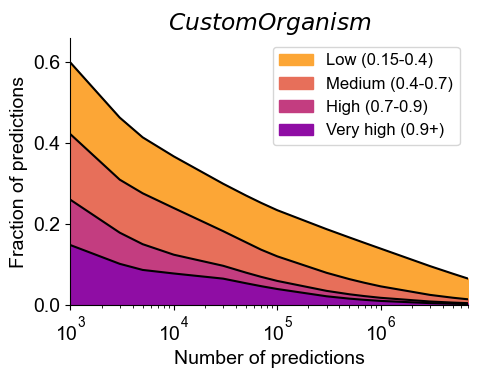


=== PPI Prediction Summary ===
Organism: Custom Organism
Total proteins: 4140
Total possible pairs: 8,567,730
STRING interactions found: 492,380 (5.75%)

Top 10000 predictions:
  Low (0.15-0.4): 3671 (36.7%)
  Medium (0.4-0.7): 2395 (23.9%)
  High (0.7-0.9): 1242 (12.4%)
  Very high (0.9+): 778 (7.8%)


In [10]:
# Prediction quality analysis
if string_scores is not None:
    # Parameters for analysis (matching human.ipynb)
    Ns = [1000, 3000, 5000, 10000, 30000, 50000, 70000, 100000, 300000, 500000, 700000, 
          1000000, 3000000, 5000000, 7000000, 10000000, 30000000, 
          50000000, 70000000, 100000000]
    thrs = [150, 400, 700, 900]
    thrs_labels = ["Low (0.15-0.4)", "Medium (0.4-0.7)", "High (0.7-0.9)", "Very high (0.9+)"]
    
    # Filter Ns to valid range
    max_predictions = len(proteomelm_scores)
    Ns = [n for n in Ns if n <= max_predictions]
    
    if len(Ns) == 0:
        logging.warning(f"Not enough predictions ({max_predictions}) for analysis")
        Ns = [min(1000, max_predictions), max_predictions]
    
    # Sort by ProteomeLM scores
    indices = np.argsort(proteomelm_scores)[::-1]
    y_sorted_by_proteomelm_score = string_scores[indices]
    
    # Calculate fraction above thresholds
    X = np.zeros((len(Ns), len(thrs)))
    for i, n in enumerate(Ns):
        for j, thr in enumerate(thrs):
            X[i, j] = np.sum(y_sorted_by_proteomelm_score[:n] >= thr) / n
    
    # Create visualization
    cmap = plt.get_cmap('plasma')
    colors = [cmap(i) for i in np.linspace(0.3, 0.8, 4)][::-1]
    
    plt.figure(figsize=(5, 4))
    for i, thr in enumerate(thrs):
        plt.plot(Ns, X[:, i], color="black", linestyle="-")
        plt.fill_between(Ns, X[:, i], alpha=1, color=colors[i], label=thrs_labels[i])
    
    plt.title(f"$\\mathbf{{\\it{{{organism_name}}}}}$", fontweight="bold")
    plt.xscale("log")
    plt.xlim(min(Ns), max(Ns))
    plt.xlabel("Number of predictions")
    plt.ylim(0, max(0.45, X.max() * 1.1))
    plt.ylabel("Fraction of predictions")
    plt.legend(fontsize=12)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    
    # Save plot
    output_file = f"fraction_above_threshold_{organism_name.lower().replace(' ', '').replace('.', '_')}.svg"
    plt.savefig(output_file, dpi=300)
    logging.info(f"Saved plot to {output_file}")
    plt.show()
    
    # Print summary statistics
    print(f"\n=== PPI Prediction Summary ===")
    print(f"Organism: {organism_name}")
    print(f"Total proteins: {len(labels)}")
    print(f"Total possible pairs: {len(proteomelm_scores):,}")
    print(f"STRING interactions found: {np.sum(string_labels):,} ({np.sum(string_labels)/len(string_labels):.2%})")
    
    # Top predictions analysis
    top_10000 = min(10000, len(proteomelm_scores))
    top_predictions_string_scores = y_sorted_by_proteomelm_score[:top_10000]

    print(f"\nTop {top_10000} predictions:")
    for i, (thr, label) in enumerate(zip(thrs, thrs_labels)):
        count = np.sum(top_predictions_string_scores >= thr)
        fraction = count / top_10000
        print(f"  {label}: {count} ({fraction:.1%})")

else:
    logging.warning("No STRING annotations available for comparison")
    print(f"\n=== PPI Prediction Summary ===")
    print(f"Organism: {organism_name}")
    print(f"Total proteins: {len(labels)}")
    print(f"Total possible pairs: {len(proteomelm_scores):,}")
    print(f"ProteomeLM score range: {proteomelm_scores.min():.3f} - {proteomelm_scores.max():.3f}")
    
    # Show top predicted pairs
    top_indices = np.argsort(proteomelm_scores)[::-1][:10]
    triu_indices = np.triu_indices(len(labels), k=1)
    
    print(f"\nTop 10 predicted interactions:")
    for rank, idx in enumerate(top_indices, 1):
        i, j = triu_indices[0][idx], triu_indices[1][idx]
        score = proteomelm_scores[idx]
        print(f"  {rank}. {labels[i]} - {labels[j]}: {score:.3f}")

## Supervised PPI Prediction using Pre-trained model

Using a trained PPI model to predict all possible protein-protein interactions in the proteome.

In [ ]:
# Full Proteome Supervised PPI Prediction
# This uses the EnhancedPPIModel from proteomelm/ppi
if supervised_ppi_checkpoint is None or not use_supervised_ppi:
    print("=== Supervised PPI Prediction with Enhanced PPI Model ===")
    print("We only support ProteomeLM-S for now")
    enhanced_model_ppi_checkpoint = "../data/interactomes/enhanced_ppi_model_bernett.pt"
    # Configuration: Try to load saved models or create new one
    device = torch.device(proteomelm_device)
                    
    # Create and configure enhanced model for this dataset
    logging.info("Creating new Enhanced PPI model for supervised prediction...")

    # Determine feature dimensions from extracted data
    pair_feature_dim = pairwise_features.shape[1]  # Flattened attention features
    protein_embed_dim = representations.shape[1]   # ProteomeLM embeddings

    # Create enhanced model with appropriate dimensions
    enhanced_model = EnhancedPPIModel(
        protein_embed_dim=protein_embed_dim,
        pair_feature_dim=pair_feature_dim,
    )
    enhanced_model.load_state_dict(torch.load(enhanced_model_ppi_checkpoint, map_location=device)["state_dict"])
    enhanced_model.to(device)
    logging.info(f"Created Enhanced PPI model with {protein_embed_dim}-dim proteins and {pair_feature_dim}-dim pairs")

    # Prepare data for the enhanced model
    logging.info("Preparing data for Enhanced PPI model...")

    # Convert to tensors
    pairwise_features_tensor = torch.tensor(pairwise_features, dtype=torch.float32).to(device)
    protein_embeddings_tensor = torch.tensor(representations, dtype=torch.float32).to(device)

    # Get pairwise indices for upper triangular matrix
    n_proteins = len(labels)
    triu_indices = np.triu_indices(n_proteins, k=1)

    # Extract protein pairs for the model
    protein1_embeddings = protein_embeddings_tensor[triu_indices[0]]
    protein2_embeddings = protein_embeddings_tensor[triu_indices[1]]

    logging.info(f"Prepared {len(protein1_embeddings)} protein pairs for prediction")

    enhanced_model.eval()
    with torch.no_grad():
        enhanced_logits = enhanced_model(
            F=pairwise_features_tensor,
            E1=protein1_embeddings,
            E2=protein2_embeddings
        )
        supervised_ppi_scores = torch.sigmoid(enhanced_logits).cpu().numpy().flatten()

    prediction_method = "Pre-trained Enhanced PPI Model"
        
    # Display prediction results
    print(f"\nPrediction method: {prediction_method}")
    print(f"Total protein pairs analyzed: {len(supervised_ppi_scores):,}")
    print(f"Prediction score range: {supervised_ppi_scores.min():.4f} - {supervised_ppi_scores.max():.4f}")
    print(f"Mean prediction score: {supervised_ppi_scores.mean():.4f}")

    # Show top predicted interactions
    top_k = min(20, len(supervised_ppi_scores))
    top_indices = np.argsort(supervised_ppi_scores)[::-1][:top_k]

    print(f"\nTop {top_k} predicted protein-protein interactions:")
    print("-" * 80)
    if string_scores is not None:
        print(f"{'Rank':<4} {'Protein 1':<20} {'Protein 2':<20} {'Score':<8} {'STRING':<8} {'Match'}")
    else:
        print(f"{'Rank':<4} {'Protein 1':<20} {'Protein 2':<20} {'Score'}")
    print("-" * 80)

    for rank, idx in enumerate(top_indices, 1):
        i, j = triu_indices[0][idx], triu_indices[1][idx]
        protein1 = labels[i][:18] + "..." if len(labels[i]) > 18 else labels[i]
        protein2 = labels[j][:18] + "..." if len(labels[j]) > 18 else labels[j]
        score = supervised_ppi_scores[idx]
        
        if string_scores is not None:
            string_score = string_scores[idx]
            match = "✓" if string_score >= 150 else "✗"
            print(f"{rank:<4} {protein1:<20} {protein2:<20} {score:<8.3f} {string_score:<8} {match}")
        else:
            print(f"{rank:<4} {protein1:<20} {protein2:<20} {score:<8.3f}")

    # Enhanced network statistics
    print(f"\n=== Enhanced Network Analysis ===")

    # Compare with STRING if available
    if string_scores is not None:
        # Calculate precision at different top-k values
        for k in [100, 500, 1000, 5000]:
            if k <= len(supervised_ppi_scores):
                top_k_indices = np.argsort(supervised_ppi_scores)[::-1][:k]
                top_k_string = string_scores[top_k_indices]
                precision = np.sum(top_k_string >= 150) / k
                print(f"Precision @ top-{k}: {precision:.3f} ({np.sum(top_k_string >= 150)}/{k} interactions)")
    # Save results
    np.save("temp_supervised_ppi_scores.npy", supervised_ppi_scores)
    print(f"\n✅ Enhanced PPI prediction completed using {prediction_method}")
    print("💾 Results saved to temp_supervised_ppi_scores.npy")

=== Supervised PPI Prediction with Enhanced PPI Model ===
We only support ProteomeLM-S for now
2025-08-15 16:09:22,830 - INFO - root - Creating new Enhanced PPI model for supervised prediction...
2025-08-15 16:09:22,884 - INFO - root - Created Enhanced PPI model with 1152-dim proteins and 48-dim pairs
2025-08-15 16:09:22,888 - INFO - root - Preparing data for Enhanced PPI model...
2025-08-15 16:09:33,483 - INFO - root - Prepared 8567730 protein pairs for prediction

Prediction method: Pre-trained Enhanced PPI Model
Total protein pairs analyzed: 8,567,730
Prediction score range: 0.0444 - 0.9746
Mean prediction score: 0.5060

Top 20 predicted protein-protein interactions:
--------------------------------------------------------------------------------
Rank Protein 1            Protein 2            Score    STRING   Match
--------------------------------------------------------------------------------
1    511145.b2606         511145.b3315         0.975    999      ✓
2    511145.b2606    

2025-08-15 16:10:20,139 - INFO - root - Saved supervised plot to fraction_above_threshold_supervised_customorganism.svg


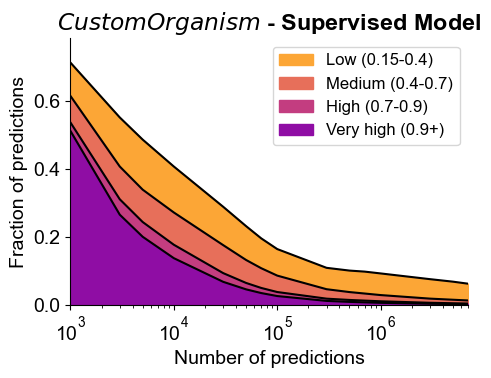


=== Supervised PPI Prediction Summary ===
Organism: Custom Organism
Total proteins: 4140
Total possible pairs: 8,567,730
STRING interactions found: 492,380 (5.75%)

Top 10000 supervised predictions:
  Low (0.15-0.4): 4073 (40.7%)
  Medium (0.4-0.7): 2721 (27.2%)
  High (0.7-0.9): 1772 (17.7%)
  Very high (0.9+): 1377 (13.8%)


In [ ]:
# Supervised prediction quality analysis
if (string_scores is not None) and use_supervised_ppi:
    # Parameters for analysis (matching previous analysis)
    Ns = [1000, 3000, 5000, 10000, 30000, 50000, 70000, 100000, 300000, 500000, 700000, 
          1000000, 3000000, 5000000, 7000000, 10000000, 30000000, 
          50000000, 70000000, 100000000]
    thrs = [150, 400, 700, 900]
    thrs_labels = ["Low (0.15-0.4)", "Medium (0.4-0.7)", "High (0.7-0.9)", "Very high (0.9+)"]
    
    # Filter Ns to valid range
    max_predictions = len(supervised_ppi_scores)
    Ns = [n for n in Ns if n <= max_predictions]
    
    if len(Ns) == 0:
        logging.warning(f"Not enough predictions ({max_predictions}) for analysis")
        Ns = [min(1000, max_predictions), max_predictions]
    
    # Sort by supervised PPI scores
    indices = np.argsort(supervised_ppi_scores)[::-1]
    y_sorted_by_supervised_score = string_scores[indices]
    
    # Calculate fraction above thresholds
    X_supervised = np.zeros((len(Ns), len(thrs)))
    for i, n in enumerate(Ns):
        for j, thr in enumerate(thrs):
            X_supervised[i, j] = np.sum(y_sorted_by_supervised_score[:n] >= thr) / n
    
    # Create visualization
    cmap = plt.get_cmap('plasma')
    colors = [cmap(i) for i in np.linspace(0.3, 0.8, 4)][::-1]
    
    plt.figure(figsize=(5, 4))
    for i, thr in enumerate(thrs):
        plt.plot(Ns, X_supervised[:, i], color="black", linestyle="-")
        plt.fill_between(Ns, X_supervised[:, i], alpha=1, color=colors[i], label=thrs_labels[i])
    
    plt.title(f"$\\mathbf{{\\it{{{organism_name}}}}}$ - Supervised Model", fontweight="bold")
    plt.xscale("log")
    plt.xlim(min(Ns), max(Ns))
    plt.xlabel("Number of predictions")
    plt.ylim(0, max(0.45, X_supervised.max() * 1.1))
    plt.ylabel("Fraction of predictions")
    plt.legend(fontsize=12)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    
    # Save plot
    output_file = f"fraction_above_threshold_supervised_{organism_name.lower().replace(' ', '').replace('.', '_')}.svg"
    plt.savefig(output_file, dpi=300)
    logging.info(f"Saved supervised plot to {output_file}")
    plt.show()
    
    # Print summary statistics
    print(f"\n=== Supervised PPI Prediction Summary ===")
    print(f"Organism: {organism_name}")
    print(f"Total proteins: {len(labels)}")
    print(f"Total possible pairs: {len(supervised_ppi_scores):,}")
    print(f"STRING interactions found: {np.sum(string_labels):,} ({np.sum(string_labels)/len(string_labels):.2%})")
    
    # Top predictions analysis
    top_10000 = min(10000, len(supervised_ppi_scores))
    top_predictions_string_scores = y_sorted_by_supervised_score[:top_10000]

    print(f"\nTop {top_10000} supervised predictions:")
    for i, (thr, label) in enumerate(zip(thrs, thrs_labels)):
        count = np.sum(top_predictions_string_scores >= thr)
        fraction = count / top_10000
        print(f"  {label}: {count} ({fraction:.1%})")

## Results Analysis and Visualization

In [38]:
# Interactive protein partner discovery
print("=== Protein Partner Discovery ===")

# Create widgets for protein selection
protein_selection_type = widgets.Dropdown(
    options=[
        ('Select specific protein', 'specific'),
        ('Random protein', 'random')
    ],
    value='specific',
    description='Selection:',
    style={'description_width': 'initial'}
)

protein_dropdown = widgets.Text(
    value=' ',
    description='Protein:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

num_partners_input = widgets.IntSlider(
    value=10,
    min=5,
    max=50,
    step=5,
    description='Top partners:',
    style={'description_width': 'initial'}
)

# Function to show/hide protein dropdown based on selection type
def update_protein_selection(change):
    if change['new'] == 'specific':
        protein_dropdown.layout.display = 'block'
    else:
        protein_dropdown.layout.display = 'none'

protein_selection_type.observe(update_protein_selection, names='value')

# Display widgets
display(protein_selection_type)
display(protein_dropdown)
display(num_partners_input)

# Function to find best partners for a protein
def find_best_partners(scores):
    # Get selected protein index
    if protein_selection_type.value == 'random':
        selected_protein_idx = np.random.choice(len(labels))
        selected_protein = labels[selected_protein_idx]
    else:
        selected_protein = protein_dropdown.value
        try:
            selected_protein_idx = labels.index(selected_protein)
        except ValueError:
            print(f"❌ Protein '{selected_protein}' not found in the dataset.")
            print(f"Available proteins: {', '.join(labels[:10])}...")
            return
    
    num_partners = num_partners_input.value
    
    print(f"\n🔍 Finding best partners for: {selected_protein}")
    print("="*60)
    
    # Get pairwise indices
    triu_indices = np.triu_indices(len(labels), k=1)
    
    # Find all pairs involving the selected protein
    partner_scores = []
    partner_indices = []
    partner_string_scores = []
    
    for pair_idx, (i, j) in enumerate(zip(triu_indices[0], triu_indices[1])):
        if i == selected_protein_idx:
            partner_idx = j
        elif j == selected_protein_idx:
            partner_idx = i
        else:
            continue
            
        partner_scores.append(scores[pair_idx])
        partner_indices.append(partner_idx)
        
        if string_scores is not None:
            partner_string_scores.append(string_scores[pair_idx])
        else:
            partner_string_scores.append(None)
    
    # Sort by ProteomeLM scores
    sorted_indices = np.argsort(partner_scores)[::-1]
    
    # Display results
    print(f"Top {num_partners} predicted interaction partners:\n")
    
    if string_scores is not None:
        print(f"{'Rank':<4} {'Partner Protein':<25} {'ProteomeLM Score':<15} {'STRING Score':<12} {'STRING Level'}")
        print("-" * 80)
    else:
        print(f"{'Rank':<4} {'Partner Protein':<25} {'ProteomeLM Score':<15}")
        print("-" * 50)
    
    for rank, idx in enumerate(sorted_indices[:num_partners], 1):
        partner_idx = partner_indices[idx]
        partner_name = labels[partner_idx]
        proteomelm_score = partner_scores[idx]
        
        if string_scores is not None:
            string_score = partner_string_scores[idx]
            
            # Determine STRING confidence level
            if string_score >= 990:
                string_level = "Verified"
            elif string_score >= 900:
                string_level = "Very high"
            elif string_score >= 700:
                string_level = "High"
            elif string_score >= 400:
                string_level = "Medium"
            elif string_score >= 150:
                string_level = "Low"
            else:
                string_level = "Unknown"

            print(f"{rank:<4} {partner_name:<25} {proteomelm_score:<15.3f} {string_score:<12} {string_level}")
        else:
            print(f"{rank:<4} {partner_name:<25} {proteomelm_score:<15.3f}")
    
    # Summary statistics
    print(f"\n📊 Summary for {selected_protein}:")
    print(f"   • Total possible partners: {len(partner_scores)}")
    print(f"   • Average ProteomeLM score: {np.mean(partner_scores):.3f}")
    print(f"   • Highest ProteomeLM score: {np.max(partner_scores):.3f}")
    
    if string_scores is not None:
        valid_string_scores = [s for s in partner_string_scores if s is not None]
        verified_confidence = sum(1 for s in valid_string_scores if s >= 990)
        very_high_confidence = sum(1 for s in valid_string_scores if s >= 900)
        high_confidence = sum(1 for s in valid_string_scores if s >= 700)
        medium_confidence = sum(1 for s in valid_string_scores if 400 <= s < 700)
        low_confidence = sum(1 for s in valid_string_scores if 150 <= s < 400)
        
        print(f"   • STRING verified partners (≥990): {verified_confidence}")
        print(f"   • STRING very high confidence partners (900-989): {very_high_confidence}")
        print(f"   • STRING high confidence partners (700-899): {high_confidence}")
        print(f"   • STRING medium confidence partners (400-699): {medium_confidence}")
        print(f"   • STRING low confidence partners (150-399): {low_confidence}")

# Button to trigger analysis
search_button = widgets.Button(
    description="🔍 Find Partners",
    button_style='info',
    layout=widgets.Layout(width='150px', margin='10px 0')
)

def on_search_click(b):
    # Unsupervised PPI prediction
    print("\n🔍 Finding best partners using unsupervised PPI prediction...")
    find_best_partners(proteomelm_scores)
    # Supervised PPI prediction
    if use_supervised_ppi and supervised_ppi_checkpoint:
        print("\n🔍 Finding best partners using supervised PPI prediction...")
        find_best_partners(supervised_ppi_scores)

search_button.on_click(on_search_click)
display(search_button)

print("\nConfigure your search parameters above and click 'Find Partners' to discover protein interactions")

=== Protein Partner Discovery ===


Dropdown(description='Selection:', options=(('Select specific protein', 'specific'), ('Random protein', 'rando…

Text(value=' ', description='Protein:', layout=Layout(width='300px'), style=TextStyle(description_width='initi…

IntSlider(value=10, description='Top partners:', max=50, min=5, step=5, style=SliderStyle(description_width='i…

Button(button_style='info', description='🔍 Find Partners', layout=Layout(margin='10px 0', width='150px'), styl…


Configure your search parameters above and click 'Find Partners' to discover protein interactions


In [39]:
find_best_partners(supervised_ppi_scores)


🔍 Finding best partners for: 511145.b4155
Top 10 predicted interaction partners:

Rank Partner Protein           ProteomeLM Score STRING Score STRING Level
--------------------------------------------------------------------------------
1    511145.b2593              0.911           0            Unknown
2    511145.b2700              0.882           0            Unknown
3    511145.b4168              0.865           0            Unknown
4    511145.b3857              0.853           0            Unknown
5    511145.b3282              0.852           0            Unknown
6    511145.b1212              0.850           373          Low
7    511145.b1233              0.847           0            Unknown
8    511145.b3412              0.845           0            Unknown
9    511145.b0147              0.838           0            Unknown
10   511145.b1707              0.835           0            Unknown

📊 Summary for 511145.b4155:
   • Total possible partners: 4139
   • Average ProteomeL

## Save Results

In [ ]:
# Save results
results = {
    "organism_name": organism_name,
    "protein_labels": labels,
    "proteomelm_scores": proteomelm_scores,
    "supervised_ppi_scores": supervised_ppi_scores,
    "pairwise_features": pairwise_features,
}

if string_scores is not None:
    results["string_scores"] = string_scores
    results["string_labels"] = string_labels

# Save to pickle file
output_file = f"ppi_results_{organism_name.lower().replace(' ', '').replace('.', '_')}.pkl"
with open(output_file, "wb") as f:
    pickle.dump(results, f)

logging.info(f"Results saved to {output_file}")

# Clean up temporary files
temp_files = ["temp_string.fa", "temp_uniprot.fa", "temp_string_annotations.txt", 
              "temp_proteome_encoded.pt", "temp_string_labels.npy"]
for temp_file in temp_files:
    if os.path.exists(temp_file):
        os.remove(temp_file)
        logging.info(f"Cleaned up {temp_file}")

print("\n=== Analysis Complete ===")
print(f"Results saved to: {output_file}")
if string_scores is not None:
    print(f"Visualization saved to: fraction_above_threshold_{organism_name.lower().replace(' ', '').replace('.', '_')}.svg")

2025-08-15 16:15:10,883 - INFO - root - Results saved to ppi_results_customorganism.pkl
2025-08-15 16:15:10,885 - INFO - root - Cleaned up temp_string.fa
2025-08-15 16:15:10,886 - INFO - root - Cleaned up temp_uniprot.fa
2025-08-15 16:15:10,894 - INFO - root - Cleaned up temp_string_annotations.txt
2025-08-15 16:15:10,904 - INFO - root - Cleaned up temp_proteome_encoded.pt
2025-08-15 16:15:10,916 - INFO - root - Cleaned up temp_string_labels.npy
2025-08-15 16:15:10,922 - INFO - root - Cleaned up temp_supervised_ppi_scores.npy

=== Analysis Complete ===
Results saved to: ppi_results_customorganism.pkl
Visualization saved to: fraction_above_threshold_customorganism.svg
Supervised visualization saved to: fraction_above_threshold_supervised_customorganism.svg
